In [1]:
import json
import os
from collections import defaultdict
from datetime import datetime, timedelta
from glob import glob
from math import asin, cos, radians, sin, sqrt
from numbers import Real
from typing import Any, Iterator, Tuple, Union
from sshtunnel import SSHTunnelForwarder

import paramiko
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import sshtunnel
import MySQLdb

from numpy import positive
from pyproj import Transformer, transform
from shapely.geometry import Point, Polygon
from sqlalchemy import (
    Connection,
    CursorResult,
    Engine,
    Select,
    TextClause,
    create_engine,
    func,
    select,
)
from sqlalchemy.sql.expression import text
from pyopensky.trino import Trino

In [2]:
LAT_MIN, LAT_MAX = 50.88385859501204322, 50.98427935836787128
LON_MIN, LON_MAX = 6.85029965503896943, 7.005 # 7.03641128126701965
ALT_MIN, ALT_MAX = 0, 750 # update from 700 m to 750 m, in line with CTR limit at 2500 ft plus margin (and accounting for Geoid Height)

TIME_BETWEEN_TRAJS = 30

# SERA.5005(f)(1) criteria
CONGESTED_ALERT_DISTANCE_M = 600      # alert distance wrt obstacles (should be 600)
CONGESTED_ALERT_DELTA_HEIGHT_M = 300   # delta height (should be 300)

# SERA.5005(f)(2) criteria
NONCONGESTED_ALERT_DISTANCE_M = 150 
NONCONGESTED_ALERT_DELTA_HEIGHT_M = 150  

CPA_MARGIN_M = 20 # allowance for lateral distance to obstacle
DIP_MARGIN_M = 20 # allowance for dip below minimum height (45m corresponds to GVA = 2)
N_MIN = 5

GEOID_HEIGHT_M = 47  # geoid height for Cologne

sshtunnel.SSH_TIMEOUT = 15.0
sshtunnel.TUNNEL_TIMEOUT = 15.0

# Setup OpenSky Network Trino credentials

In [7]:
OSN_secrets_json = './trino_secrets.json'
MYSQL_secrets_json = './mysql_secrets.json'

with open(OSN_secrets_json) as OSN_secrets:
  OSN_creds = json.load(OSN_secrets)

with open(MYSQL_secrets_json) as MYSQL_secrets:
  MYSQL_creds = json.load(MYSQL_secrets)

os.environ['OPENSKY_USERNAME'] = OSN_creds['OPENSKY_USERNAME']
os.environ['OPENSKY_PASSWORD'] = OSN_creds['OPENSKY_PASSWORD']

# Test connection with basic SQL query

In [8]:
trino = Trino()

query = "select * from operational_status_data4 limit 5"

df = trino.query(query, cached = False)

Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:98)
    at r.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:2:1637)
    at h.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:1:13958)
    at u (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:9338)
    at O

Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/c0d6d9ebfafe8055ecbe1c877b820683842255fef880f37030c8a57f80f56145


FINISHED: : 15.9% [00:00, 146%/s]
DOWNLOAD: 5.00lines [00:00, 105lines/s]


In [9]:
df

,sensors,rawmsg,icao24,mintime,maxtime,msgcount,subtypecode,unknowncapcode,unknownopcode,hasoperationaltcas,...,airplanewidth,version,nicsupplementa,positionnac,geometricverticalaccuracy,sourceintegritylevel,barometricaltitudeintegritycode,trackheadinginfo,horizontalreferencedirection,hour
0,"[(serial: -1408231736, mintime: 1656653136.679...",8d485122f82300020049b88c1acb,485122,1.656653e+09,1.656653e+09,1,0,False,False,1,...,None,2,False,9.0,-1,3,1,None,False,1656651600
1,"[(serial: -1408234983, mintime: 1656653136.701...",8d485122f82300020049b88c1acb,485122,1.656653e+09,1.656653e+09,1,0,False,False,1,...,None,2,False,9.0,-1,3,1,None,False,1656651600
2,"[(serial: -1408232917, mintime: 1656653136.704...",8d485122f82300020049b88c1acb,485122,1.656653e+09,1.656653e+09,1,0,False,False,1,...,None,2,False,9.0,-1,3,1,None,False,1656651600
3,"[(serial: -1408236446, mintime: 1656653136.725...",8d485122f82300020049b88c1acb,485122,1.656653e+09,1.656653e+09,1,0,False,False,1,...,None,2,False,9.0,-1,3,1,None,False,1656651600
4,"[(serial: -1408233674, mintime: 1656653136.742...",8d485122f82300020049b88c1acb,485122,1.656653e+09,1.656653e+09,1,0,False,False,1,...,None,2,False,9.0,-1,3,1,None,False,1656651600


# Send queries and merge results

In [10]:
start_str = "01/09/24"
end_str = "30/09/24"

start = datetime.strptime(start_str, '%d/%m/%y')
end = datetime.strptime(end_str, '%d/%m/%y')

# Modify start_date to be 00:00:00
start = start.replace(hour=0, minute=0, second=1, microsecond=0)
# Modify end_date to be 23:59:59
end = end.replace(hour=23, minute=59, second=59, microsecond=999999)

start_time = int(start.timestamp())
start_hour = start_time - (start_time % 3600)
end_time = int(end.timestamp())
end_hour = end_time - (end_time % 3600)

In [11]:
svdata4_query = (
        f"SELECT * FROM state_vectors_data4"
        f" WHERE icao24 LIKE '%'"
        f" AND time >= {start_time} AND time <= {end_time}"
        f" AND hour >= {start_hour} AND hour <= {end_hour}"
        f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
        f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
        f" AND geoaltitude >= {ALT_MIN} AND geoaltitude <= {ALT_MAX}"
        f" ORDER BY time"
    )

trino = Trino()

svdata4_df = trino.query(
    svdata4_query,
    cached=False,
    compress=True,
)

Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:98)
    at r.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:2:1637)
    at h.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:1:13958)
    at u (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:9338)
    at O

Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/46f523a4d0a5da15fc559d6d6ba28368f28ff120bf3e9cf52c4ed1b35745e0a1


FINISHING: : 100% [00:06, 16.3%/s]
DOWNLOAD: 71.8klines [00:03, 22.7klines/s]


In [12]:
# Save svdata4 pickle
svdata4_df.to_pickle('./OSN_pickles/svdata4df_new_2024-09-01_2024-09-30.pkl')

In [6]:
# OR Read a saved pickle

svdata4_df = pd.read_pickle('./OSN_pickles/svdata4df_new_2024-08-01_2024-08-31.pkl')

In [13]:
len(svdata4_df.hour.unique())

225

In [14]:
len(svdata4_df.icao24.unique())

110

/tmp/ipykernel_26595/3399700428.py:7: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(svdata4_df['lon'], svdata4_df['lat'], c=svdata4_df['geoaltitude'], cmap='Reds', alpha=0.7, marker='x', edgecolor='k')


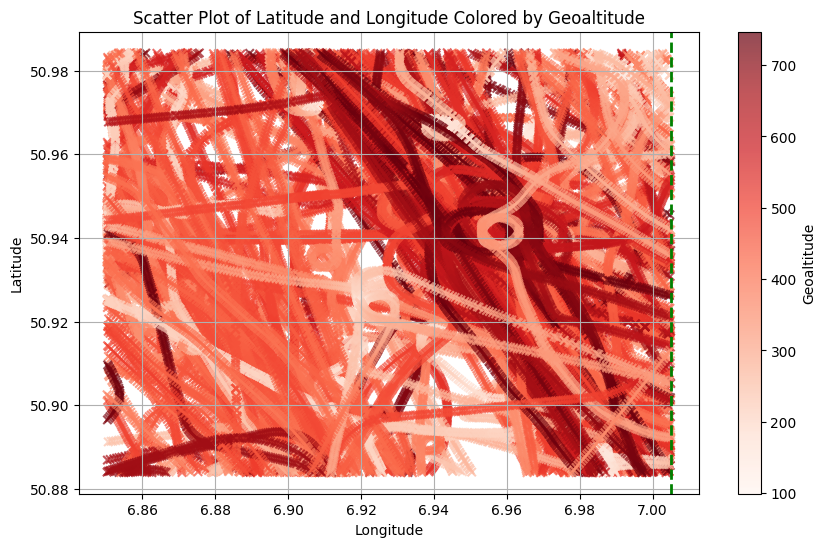

In [15]:
import matplotlib.pyplot as plt

# Assuming your dataframe is svdata4_df and it has 'lat', 'lon', and 'geoaltitude' columns
plt.figure(figsize=(10, 6))

# Create the scatter plot with colors based on 'geoaltitude'
sc = plt.scatter(svdata4_df['lon'], svdata4_df['lat'], c=svdata4_df['geoaltitude'], cmap='Reds', alpha=0.7, marker='x', edgecolor='k')

# Add a color bar to show the geoaltitude scale
cbar = plt.colorbar(sc)
cbar.set_label('Geoaltitude')

# Add a vertical line at lon = 7.005
plt.axvline(x=7.005, color='green', linestyle='--', linewidth=2)

# Add labels and title
plt.title('Scatter Plot of Latitude and Longitude Colored by Geoaltitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.grid(True)
plt.show()


In [16]:
icao_list = svdata4_df.icao24.unique()
icao24_str = ', '.join(f"'{item}'" for item in icao_list)

ops_sts_query = (
    f"SELECT icao24, mintime, maxtime, nacv, systemdesignassurance, version, positionnac, geometricverticalaccuracy, sourceintegritylevel, barometricaltitudeintegritycode  FROM operational_status_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
ops_sts_df = trino.query(
    ops_sts_query,
    cached=False,
)

ops_sts_df['time'] = ops_sts_df['mintime'].astype('int64')

Connecting to OSN database...


Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:98)
    at r.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:2:1637)
    at h.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:1:13958)
    at u (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:9338)
    at O

Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/e9eac0ac7ac5db34611f04f6f9ce01d836fc3ab70abe5b18dd3dbf3efcc21408


RUNNING: : 98.8% [00:02, 33.5%/s]
DOWNLOAD: 5.08Mlines [04:56, 17.1klines/s]


In [17]:
# Save ops_sts pickle
ops_sts_df.to_pickle('./OSN_pickles/opsstsdf_new_2024-09-01_2024-09-30.pkl')

In [18]:
# Initialize an empty DataFrame to hold the results
merged_df = pd.DataFrame()

# Loop over each unique 'icao24' in both dataframes
unique_icao24s = pd.concat([svdata4_df['icao24'], ops_sts_df['icao24']]).unique()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = svdata4_df[svdata4_df['icao24'] == icao24]
    sub_df2 = ops_sts_df[ops_sts_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    merged_df = pd.concat([merged_df, merged_sub_df], ignore_index=True)


In [19]:
posdata4_query = (
    f"SELECT mintime, icao24, nic  FROM position_data4"
    f" WHERE icao24 IN ({icao24_str})"
    f" AND lat >= {LAT_MIN} AND lat <= {LAT_MAX}"
    f" AND lon>= {LON_MIN} AND lon <= {LON_MAX}"
    f" AND mintime >= {start_time} AND maxtime <= {end_time}"
    f" AND hour >= {start_hour} AND hour <= {end_hour}"
    f" ORDER by mintime"
)

print('Connecting to OSN database...')
trino = Trino()
posdata4_df = trino.query(
    posdata4_query,
    cached=False,
)

posdata4_df['time'] = posdata4_df['mintime'].astype('int64')

Connecting to OSN database...


Loading "original-fs" failed
Error: Cannot find module 'original-fs'
Require stack:
- /home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js
    at Module._resolveFilename (node:internal/modules/cjs/loader:1145:15)
    at Module._load (node:internal/modules/cjs/loader:986:27)
    at Module.require (node:internal/modules/cjs/loader:1233:19)
    at require (node:internal/modules/helpers:179:18)
    at i (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:98)
    at r.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:2:1637)
    at h.load (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:1:13958)
    at u (/home/dimitri/.vscode-server/cli/servers/Stable-eaa41d57266683296de7d118f574d0c2652e1fc4/server/out/server-cli.js:3:9338)
    at O

Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/93373c5eba0bf43ffac9b9d08ca35b2d474303dae6afb79a2cf0e0dcc15b200e


FINISHING: : 100% [00:02, 41.5%/s]
DOWNLOAD: 194klines [00:03, 64.3klines/s]


In [20]:
# Save ops_sts pickle
posdata4_df.to_pickle('./OSN_pickles/posdata4df_new_2024-09-01_2024-09-30.pkl')

In [21]:
# Initialize an empty DataFrame to hold the results
final_df = pd.DataFrame()

for icao24 in unique_icao24s:
    # Filter each dataframe by 'icao24'
    sub_df1 = merged_df[merged_df['icao24'] == icao24]
    sub_df2 = posdata4_df[posdata4_df['icao24'] == icao24]

    # Ensure both sub-dataframes are sorted by 'time'
    sub_df1 = sub_df1.sort_values('time')
    sub_df2 = sub_df2.sort_values('time')

    # Perform merge_asof on the filtered and sorted dataframes
    merged_sub_df = pd.merge_asof(sub_df1, sub_df2, on='time', by='icao24', direction='backward')
    
    # Append the result to the main dataframe
    final_df = pd.concat([final_df, merged_sub_df], ignore_index=True)

final_df = final_df.drop(columns=['hour', 'mintime_x', 'maxtime', 'mintime_y'])


# Add DEM ground elevation information

In [22]:
crs_transformer = Transformer.from_crs(4326, 25832, always_xy = True) # Transformer from WGS-84 to ETRS89-LAEA (3035 for EU-DEM v1.1, 25832 for LAS DEM)

def transform_coords(lon, lat):
    return crs_transformer.transform(lon, lat)

In [23]:
final_df['gnd_elev'] = np.nan

dem_src = rasterio.open('./resources/Cologne_DEM_merged_from_LAS_25x25.tif')

final_df['etrs89_x'], final_df['etrs89_y'] = zip(*final_df.apply(lambda row: transform_coords(row['lon'], row['lat']), axis=1))


In [24]:
def get_elevation(x, y, dem, default_value=None):
    try:
        row, col = dem.index(x, y)
        return dem.read(1)[row, col]
    except IndexError:
        return default_value

# If you already have 'gnd_elev' in your dataframe, you can pass it as the default_value
final_df['gnd_elev'] = final_df.apply(
    lambda row: get_elevation(row['etrs89_x'], row['etrs89_y'], dem_src, row.get('gnd_elev', None)), 
    axis=1
)

In [25]:
missing_elev_count = final_df['gnd_elev'].isnull().sum()
print(f"Number of rows with None or NaN in 'gnd_elev': {missing_elev_count}")
final_df = final_df.dropna(subset=['gnd_elev'])


Number of rows with None or NaN in 'gnd_elev': 366


# Add population density

In [26]:
final_df['pop_density'] = np.nan

pop_src = rasterio.open('./resources/GHS_POP_E2020_GLOBE_R2023A_4326_3ss_V1_0_Cologne.tif')

def get_population(lon, lat, pop_src):
    row, col = pop_src.index(lon, lat)
    return pop_src.read(1)[row, col]

final_df['pop_density'] = final_df.apply(lambda row: get_population(row['lon'], row['lat'], pop_src), axis=1)


# Process df with distance information

In [27]:
def haversine(pt1, pt2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returned units are in metres. Differs slightly from PostGIS geography
    distance, which uses a spheroid, rather than a sphere.
    """

    lat1, lon1 = pt1[0], pt1[1]
    lat2, lon2 = pt2[0], pt2[1]

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.0) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in m
    return c * r

In [28]:
final_df["prev_time"] = final_df.time.shift()
final_df['closest_obst_name'] = ''
final_df['inf_flt'] = False
final_df['inf_pt'] = False
final_df['gnd_inf_flt'] = False
final_df['gnd_inf_pt'] = False
final_df['min_hgt'] = np.nan
final_df['congested'] = final_df['pop_density'] > 2

map_time_traj = defaultdict(dict)

for icao, sfinal_df in final_df.groupby("icao24"):
    map_time_traj[icao][sfinal_df.iloc[0]["time"]] = icao + "_1"
    n_traj = 1
    for i in range(1, sfinal_df.shape[0]):
        time = sfinal_df.iloc[i]["time"]
        diff = abs(int(time) - int(sfinal_df.iloc[i]["prev_time"]))
        if diff > TIME_BETWEEN_TRAJS:
            n_traj += 1
        map_time_traj[icao][time] = icao + "_" + str(int(n_traj))

final_df['ref'] = final_df.apply(lambda x: map_time_traj[x.icao24][x.time], axis=1) + '_' + final_df.time.apply(lambda x: pd.to_datetime(x, unit='s').strftime("%d%m%y"))

# Add a distance column and compute cumulative along-track distance for each flight
final_df['dist'] = 0.0
for flight in final_df.ref.unique():
  first = True
  current = final_df[final_df['ref'].isin([flight])] # gets the trajectory of the current flight
  for row in current.itertuples():
    if not(first):
      current_pt = (float(row.lat), float(row.lon))
      delta_dist = haversine(previous_pt, current_pt)
      final_df.loc[row[0],'dist'] = previous_dist + delta_dist
    previous_pt = (float(row.lat), float(row.lon))
    previous_dist = final_df.loc[row[0],'dist']
    first = False


# Load obstacle information and check min height

In [29]:
path_to_obstacles_json = './resources/LAC_obstacles_v1.csv'

obs_df = pd.read_csv(path_to_obstacles_json)

obs_df.rename(columns={'h': 'height_m'}, inplace=True)

obs_df = obs_df.sort_values(by=['height_m']) # sort obstacles by incresing height, to avoid that the min_hgt profil is wrong if a shorter obstacle comes after a taller one, in case the aircraft is within two obstacles clearance areas


In [40]:
# new. Test if this should not be done before adding the ref and distance info
final_df_bkp = final_df.copy()
final_df = final_df.reset_index(drop = True)

In [41]:
def update_closest_obstacle_xy(final_df, obstacles_df):

    # Extract the coordinates and obstacle heights
    final_coords = final_df[['etrs89_x', 'etrs89_y']].to_numpy()
    obstacle_coords = obstacles_df[['x', 'y']].to_numpy()
    obstacle_heights = obstacles_df['height_m'].to_numpy()
    obstacle_names = obstacles_df['LAC_Name'].to_numpy()
    obstacle_ground_elevs = obstacles_df['gnd_elev'].to_numpy()

    # Iterate over each point in final_df and calculate distances
    for i, (x_f, y_f) in enumerate(final_coords):

        radius = (CONGESTED_ALERT_DISTANCE_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DISTANCE_M)

        # Convert radius to a squared radius for comparison with squared distances (faster than computing square roots)
        squared_radius = radius ** 2

        # Calculate squared Euclidean distances to all obstacles
        distances_sq = (obstacle_coords[:, 0] - x_f) ** 2 + (obstacle_coords[:, 1] - y_f) ** 2
        
        # Filter obstacles within the radius
        within_radius = distances_sq <= squared_radius
        
        # If there are obstacles within the radius, find the tallest one
        if np.any(within_radius):
            # Get the indices of obstacles within the radius
            obstacles_in_radius_idx = np.where(within_radius)[0]
            
            # Find the index of the tallest obstacle within the radius
            tallest_idx = obstacles_in_radius_idx[np.argmax(obstacle_heights[obstacles_in_radius_idx])]
            
            # Update final_df with the tallest obstacle details
            tallest_obstacle_name = obstacle_names[tallest_idx]
            tallest_obstacle_height = obstacle_heights[tallest_idx]
            tallest_obstacle_elev = obstacle_ground_elevs[tallest_idx]
            
            final_df.at[i, 'closest_obst_name'] = tallest_obstacle_name

            final_df.at[i, 'min_hgt'] = (
                GEOID_HEIGHT_M + np.float32(tallest_obstacle_elev) +
                np.float32(tallest_obstacle_height) + 
                (CONGESTED_ALERT_DELTA_HEIGHT_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DELTA_HEIGHT_M)
            )
        else:
            final_df.at[i, 'closest_obst_name'] = 'ground'
            final_df.at[i, 'min_hgt'] = (CONGESTED_ALERT_DELTA_HEIGHT_M if final_df.at[i, 'congested'] else NONCONGESTED_ALERT_DELTA_HEIGHT_M)

    return final_df


In [42]:
final_df = update_closest_obstacle_xy(final_df, obs_df)

final_df['dip'] = final_df['min_hgt'] - final_df['geoaltitude']

# Add infraction information

In [43]:
# Rule for 'inf_pt'
final_df['inf_pt'] = final_df.apply(
    lambda row: 
        True if row['dip'] > 0 and row['closest_obst_name'] != 'ground' 
    else 
        False,
    axis=1
)

# Rule for 'gnd_inf_pt'
final_df['gnd_inf_pt'] = final_df.apply(
    lambda row: True if (row['dip'] > 0 and row['closest_obst_name'] == 'ground') else False,
    axis=1
)

# Group by 'ref' and update 'inf_flt' based on 'inf_pt'
final_df['inf_flt'] = final_df.groupby('ref')['inf_pt'].transform('any')

# Group by 'ref' and update 'gnd_inf_flt' based on 'gnd_inf_pt'
final_df['gnd_inf_flt'] = final_df.groupby('ref')['gnd_inf_pt'].transform('any')

final_df = final_df.drop(columns=['serials', 'nacv'])


In [44]:
final_df[final_df['gnd_inf_pt']].callsign.unique()

array([None, 'CHX3    ', 'DHHAL   ', 'DHAIY   ', 'BPO160  ', 'CHX76   ',
       'HUMMEL6 ', 'HUMMEL1 ', 'JOKER42 ', 'HUMMEL5 ', 'CHX09   ',
       'DHSKI   ', 'DHHAB   ', 'SWT2CW  ', 'HUMMEL4 ', 'DHAIU   ',
       'CHX75   '], dtype=object)

In [45]:
missing_callsign = final_df['callsign'].isnull().sum()
print(f"Number of rows with None or NaN in 'callsign': {missing_callsign}")
final_df = final_df.dropna(subset=['callsign'])

Number of rows with None or NaN in 'callsign': 66


# Create infraction tables

In [46]:
inf_result = pd.DataFrame
gnd_inf_result = pd.DataFrame()

In [47]:
inf_pt_df = final_df[final_df.inf_pt].copy()

#lat, lon = obs_df.loc[obs_df['name'] == 'Ringturm', ['lat', 'lon']].values[0]

inf_pt_df['dist_to_obs'] = np.nan

inf_pt_df['dist_to_obs'] = inf_pt_df.apply(
    lambda x: haversine(
            (obs_df.loc[obs_df['LAC_Name'] == x['closest_obst_name'], 'lat'].iloc[0],
            obs_df.loc[obs_df['LAC_Name'] == x['closest_obst_name'], 'lon'].iloc[0]),
            (x['lat'], x['lon'])
    ) if not (x['closest_obst_name'] == 'ground') else np.nan, 
    axis=1
)

inf_pt_df['time'] = pd.to_datetime(inf_pt_df['time'], unit='s')
inf_pt_df = inf_pt_df.sort_values(by=['ref', 'closest_obst_name', 'time'])

inf_pt_df['time_diff'] = inf_pt_df.groupby(['ref', 'closest_obst_name'])['time'].diff()
inf_pt_df['group'] = (inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

inf_grouped = inf_pt_df.groupby(['ref', 'closest_obst_name', 'group'])

inf_min_dist = inf_grouped.apply(lambda x: x.loc[x['dist_to_obs'].idxmin()]).reset_index(drop=True)
inf_max_dip = inf_grouped['dip'].max().reset_index()

group_size = inf_grouped.size().reset_index(name='n')

inf_result = inf_min_dist[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dist_to_obs', 'congested', 'pop_density', 'systemdesignassurance', 'version', 'positionnac', 'sourceintegritylevel', 'nic']].copy()
inf_result = inf_result.merge(inf_max_dip, on=['ref', 'closest_obst_name', 'group'])
inf_result = inf_result.merge(group_size, on=['ref', 'closest_obst_name', 'group'])

inf_result.rename(columns={'dist_to_obs': 'cpa', 'dip': 'dip_max'}, inplace=True)

inf_result['entry_count'] = inf_result.groupby('ref').cumcount()
inf_result['inf_ref'] = inf_result['ref'].astype(str) + '_' + inf_result['entry_count'].astype(str)

inf_result['url'] = inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

inf_result = inf_result.reset_index(drop=True)

inf_result = inf_result.drop(columns=['entry_count', 'group'])

In [48]:
inf_result

,icao24,callsign,ref,closest_obst_name,time,lat,lon,cpa,congested,pop_density,systemdesignassurance,version,positionnac,sourceintegritylevel,nic,dip_max,n,inf_ref,url
0,398338,FHAZY,398338_1_050924,AREO Turm,2024-09-05 18:54:02,50.914352,6.966965,395.997842,True,25.732103,2,2,10.0,3,9,19.700000,17,398338_1_050924_0,https://globe.adsbexchange.com/?icao=398338&la...
1,398338,FHAZY,398338_1_050924,Colonius FernsehturmColonius Fernsehturm,2024-09-05 18:52:07,50.947083,6.932447,36.547277,True,3.437461,2,2,10.0,3,9,88.359985,30,398338_1_050924_1,https://globe.adsbexchange.com/?icao=398338&la...
2,398338,FHAZY,398338_1_050924,Krohstr. 4 (Bayenthal),2024-09-05 18:54:23,50.908813,6.974240,207.934854,True,36.879350,2,2,10.0,3,9,35.500002,30,398338_1_050924_2,https://globe.adsbexchange.com/?icao=398338&la...
3,398338,FHAZY,398338_1_050924,Rodenkirchener Bruecke 1,2024-09-05 18:55:04,50.899017,6.988864,321.243882,True,4.585226,2,2,10.0,3,9,20.599999,21,398338_1_050924_3,https://globe.adsbexchange.com/?icao=398338&la...
4,398338,FHAZY,398338_1_050924,Rodenkirchener Bruecke 2,2024-09-05 18:55:19,50.895721,6.994208,467.431727,True,82.796584,2,2,10.0,3,9,20.550003,4,398338_1_050924_4,https://globe.adsbexchange.com/?icao=398338&la...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,a08c71,N1340M,a08c71_1_120924,Institusgebauede 1,2024-09-12 12:50:56,50.938716,6.862259,558.876856,True,23.799059,2,2,10.0,3,9,30.440002,1,a08c71_1_120924_0,https://globe.adsbexchange.com/?icao=a08c71&la...
918,a08c71,N1340M,a08c71_1_120924,RheinEnergie Stadion 4,2024-09-12 12:50:44,50.931221,6.868896,399.312669,True,20.106741,2,2,10.0,3,9,38.900001,8,a08c71_1_120924_1,https://globe.adsbexchange.com/?icao=a08c71&la...
919,a08c71,N1340M,a08c71_1_120924,Wohnheim Sporthochschule,2024-09-12 12:50:51,50.935597,6.865082,463.261328,True,40.899443,2,2,10.0,3,9,46.880000,10,a08c71_1_120924_2,https://globe.adsbexchange.com/?icao=a08c71&la...
920,a34669,N31VX,a34669_1_270924,Venloer Straße 601-603,2024-09-27 08:53:37,50.958221,6.891785,569.157008,True,7.716641,2,2,10.0,3,9,10.640003,5,a34669_1_270924_0,https://globe.adsbexchange.com/?icao=a34669&la...


Ground infractions

In [49]:
gnd_inf_pt_df = final_df[final_df.gnd_inf_pt & (final_df.dip >= 0) & (final_df.closest_obst_name == 'ground')].copy()

gnd_inf_pt_df['time'] = pd.to_datetime(gnd_inf_pt_df['time'], unit='s')
gnd_inf_pt_df = gnd_inf_pt_df.sort_values(by=['ref', 'time'])

gnd_inf_pt_df['time_diff'] = gnd_inf_pt_df.groupby(['ref'])['time'].diff()
gnd_inf_pt_df['group'] = (gnd_inf_pt_df['time_diff'] >= pd.Timedelta(seconds=30)).cumsum()

gnd_inf_grouped = gnd_inf_pt_df.groupby(['ref', 'group'])

gnd_inf_max_dip = gnd_inf_grouped.apply(lambda x: x.loc[x['dip'].idxmax()]).reset_index(drop=True)

group_size = gnd_inf_grouped.size().reset_index(name='n')

gnd_inf_result = gnd_inf_max_dip[['icao24', 'callsign', 'group', 'ref', 'closest_obst_name', 'time', 'lat', 'lon', 'dip', 'congested', 'pop_density', 'systemdesignassurance', 'version', 'positionnac', 'sourceintegritylevel', 'nic']].copy()

gnd_inf_result = gnd_inf_result.merge(group_size, on=['ref', 'group'])

gnd_inf_result.rename(columns={'dip': 'dip_max'}, inplace=True)

gnd_inf_result['entry_count'] = gnd_inf_result.groupby('ref').cumcount()
gnd_inf_result['inf_ref'] = gnd_inf_result['ref'].astype(str) + '_' + 'gnd_' + gnd_inf_result['entry_count'].astype(str)

gnd_inf_result['url'] = gnd_inf_result.apply(lambda row: "https://globe.adsbexchange.com/?icao=%s&lat=50.928&lon=6.947&zoom=13.2&showTrace=%s&timestamp=%s" % (
    row['icao24'],
    row['time'].strftime('%Y-%m-%d'),
    str(int(row['time'].timestamp()))
), axis=1)

gnd_inf_result = gnd_inf_result.reset_index(drop=True)

gnd_inf_result = gnd_inf_result.drop(columns=['entry_count', 'group'])



In [50]:
gnd_inf_result.callsign.unique()

array(['SWT2CW  ', 'DHAIU   ', 'DHAIY   ', 'CHX75   ', 'DHHAB   ',
       'DHHAL   ', 'HUMMEL1 ', 'HUMMEL4 ', 'HUMMEL5 ', 'HUMMEL6 ',
       'DHSKI   ', 'CHX3    ', 'BPO160  ', 'CHX76   ', 'CHX09   ',
       'JOKER42 '], dtype=object)

In [51]:
gnd_inf_result.columns

Index(['icao24', 'callsign', 'ref', 'closest_obst_name', 'time', 'lat', 'lon',
       'dip_max', 'congested', 'pop_density', 'systemdesignassurance',
       'version', 'positionnac', 'sourceintegritylevel', 'nic', 'n', 'inf_ref',
       'url'],
      dtype='object')

In [52]:
inf_result.columns

Index(['icao24', 'callsign', 'ref', 'closest_obst_name', 'time', 'lat', 'lon',
       'cpa', 'congested', 'pop_density', 'systemdesignassurance', 'version',
       'positionnac', 'sourceintegritylevel', 'nic', 'dip_max', 'n', 'inf_ref',
       'url'],
      dtype='object')

# Upload data to MySQL server

In [53]:
ed25519_key = paramiko.Ed25519Key(filename='/home/dimitri/.ssh/id_ed25519')

# Set up the SSH tunnel with the RSA key
with SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS'], 22),
    ssh_username=MYSQL_creds['SSH_USERNAME'],
    ssh_pkey=ed25519_key,  # Use the loaded RSA key
    remote_bind_address=(MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT']),
    allow_agent=False,
) as tunnel:
    
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['PROD_DATABASE_NAME']

    engine = create_engine(engstr)

    print('step 1')
    final_df.to_sql(con=engine, name = MYSQL_creds['MAIN_PROD_TABLE_NAME'], if_exists='append')
    print('step 2')
    inf_result.to_sql(con=engine, name = MYSQL_creds['INF_PROD_TABLE_NAME'], if_exists='append')
    print('step 3')
    gnd_inf_result.to_sql(con=engine, name = MYSQL_creds['GNDINF_PROD_TABLE_NAME'], if_exists='append')

    print("Done")

connected
step 1
step 2
step 3
Done


# View results

In [54]:
inf_result

,icao24,callsign,ref,closest_obst_name,time,lat,lon,cpa,congested,pop_density,systemdesignassurance,version,positionnac,sourceintegritylevel,nic,dip_max,n,inf_ref,url
0,398338,FHAZY,398338_1_050924,AREO Turm,2024-09-05 18:54:02,50.914352,6.966965,395.997842,True,25.732103,2,2,10.0,3,9,19.700000,17,398338_1_050924_0,https://globe.adsbexchange.com/?icao=398338&la...
1,398338,FHAZY,398338_1_050924,Colonius FernsehturmColonius Fernsehturm,2024-09-05 18:52:07,50.947083,6.932447,36.547277,True,3.437461,2,2,10.0,3,9,88.359985,30,398338_1_050924_1,https://globe.adsbexchange.com/?icao=398338&la...
2,398338,FHAZY,398338_1_050924,Krohstr. 4 (Bayenthal),2024-09-05 18:54:23,50.908813,6.974240,207.934854,True,36.879350,2,2,10.0,3,9,35.500002,30,398338_1_050924_2,https://globe.adsbexchange.com/?icao=398338&la...
3,398338,FHAZY,398338_1_050924,Rodenkirchener Bruecke 1,2024-09-05 18:55:04,50.899017,6.988864,321.243882,True,4.585226,2,2,10.0,3,9,20.599999,21,398338_1_050924_3,https://globe.adsbexchange.com/?icao=398338&la...
4,398338,FHAZY,398338_1_050924,Rodenkirchener Bruecke 2,2024-09-05 18:55:19,50.895721,6.994208,467.431727,True,82.796584,2,2,10.0,3,9,20.550003,4,398338_1_050924_4,https://globe.adsbexchange.com/?icao=398338&la...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,a08c71,N1340M,a08c71_1_120924,Institusgebauede 1,2024-09-12 12:50:56,50.938716,6.862259,558.876856,True,23.799059,2,2,10.0,3,9,30.440002,1,a08c71_1_120924_0,https://globe.adsbexchange.com/?icao=a08c71&la...
918,a08c71,N1340M,a08c71_1_120924,RheinEnergie Stadion 4,2024-09-12 12:50:44,50.931221,6.868896,399.312669,True,20.106741,2,2,10.0,3,9,38.900001,8,a08c71_1_120924_1,https://globe.adsbexchange.com/?icao=a08c71&la...
919,a08c71,N1340M,a08c71_1_120924,Wohnheim Sporthochschule,2024-09-12 12:50:51,50.935597,6.865082,463.261328,True,40.899443,2,2,10.0,3,9,46.880000,10,a08c71_1_120924_2,https://globe.adsbexchange.com/?icao=a08c71&la...
920,a34669,N31VX,a34669_1_270924,Venloer Straße 601-603,2024-09-27 08:53:37,50.958221,6.891785,569.157008,True,7.716641,2,2,10.0,3,9,10.640003,5,a34669_1_270924_0,https://globe.adsbexchange.com/?icao=a34669&la...


# Load Distant data for tests

In [221]:
with sshtunnel.SSHTunnelForwarder(
    (MYSQL_creds['SSH_ADDRESS']),
    ssh_username = MYSQL_creds['SSH_USERNAME'], ssh_password = MYSQL_creds['SSH_PASSWORD'],
    remote_bind_address = (MYSQL_creds['REMOTE_BIND_ADDRESS'], MYSQL_creds['REMOTE_BIND_PORT'])
) as tunnel:
    print('connected')

    engstr =  'mysql+pymysql://' + MYSQL_creds['SSH_USERNAME'] + ':' + MYSQL_creds['PYANYWHERE_PASSWORD'] + '@127.0.0.1:' + str(tunnel.local_bind_port)+'/dme3$' + MYSQL_creds['TEST_DATABASE_NAME']

    engine = create_engine(engstr)

    sql_query = """
    SELECT ref, lat, lon 
    FROM main_data_test
    WHERE positionnac >= 8
    """
    
    distant_df = pd.read_sql(sql_query, con=engine)

connected


In [ ]:
SELECT 
    COLUMN_NAME, 
    IS_NULLABLE 
FROM 
    INFORMATION_SCHEMA.COLUMNS 
WHERE 
    TABLE_NAME = 'main_data_test' 
    AND TABLE_SCHEMA = 'testdatabase';